### Louis-Antoine LeBel
#### ID: 40175005
#### COMP 333
#### Lab Assignment 2

#### Task Description
The purpose of this assignment is to enhance three datasets with metadata and to then create a function simpleDDA() which returns a dataframe containing information about the overall description, Central Tendency and Spread. simpleDDA() also plots the features of the datasets.

#### PART A

In [149]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

To clearly seperate parts A, B and C, I separated SimpleDDA() in three functions (which are then called in SimpleDDA())

In [150]:
def SimpleDDA_A(dfWithMeta):
    # colums of DDAdescription for Overall Descriptions
    cols =  ['feature', 'observations', 'entries', 'unique entries', 'missing entries']
    DDAdescription = pd.DataFrame(columns = cols) # create empty dataframe with columns

    #iterate through each column of df. I'm adding one row at a time to DDAdescription
    for col in dfWithMeta['df']:
        ser = dfWithMeta['df'][col] #get series of the column

        entries = ser.notnull().sum()
        missing = ser.isnull().sum()
        observations = entries + missing
        unique = ser.nunique()

        # add row to DDAdescription with index as feature of df
        row = pd.Series({'feature': col, 'observations': observations, 'entries': entries, 'unique entries': unique, 'missing entries': missing}, name = col)
        DDAdescription.loc[len(DDAdescription.index)] = row

    DDAdescription.set_index('feature', inplace=True)
    return DDAdescription

#### PART B

In [151]:
def SimpleDDA_B(dfWithMeta):
    # columns for central tendency & spread
    cols =  ['feature', 'mode(s)', 'median', 'mean', 'range', 'IQR', 'σ']
    DDAdescription = pd.DataFrame(columns = cols) # create empty dataframe with columns

    #iterate through each column of df. I'm adding one row at a time to DDAdescription
    for col in dfWithMeta['df']:
        ser = dfWithMeta['df'][col] #get series of the column
        
        mode = list(ser.mode()) #mode

        # at first set every value to NaN (and change them later based on feature type)
        median = np.nan
        range = np.nan
        iqr = np.nan
        st_dev = np.nan
        mean = np.nan

        # Central tendency for Ordinal features
        if dfWithMeta['data_types'][col] == 'ordinal':
            # replace ordinal values with numerical values corresponding to their order
            numerical = pd.Series(list(map(lambda x: dfWithMeta['ordinal_values'][col].index(x), ser.dropna())))
            # calculate median
            median = dfWithMeta['ordinal_values'][col][int(numerical.median())] if numerical.median().is_integer() else np.nan
            # get range
            range = [dfWithMeta['ordinal_values'][col][int(numerical.min())], dfWithMeta['ordinal_values'][col][int(numerical.max())]] # correct this

        # central tendency for intercal and ratio features
        elif dfWithMeta['data_types'][col] in ['interval', 'ratio']:
            # central tendency
            median = ser.median()
            range = [ser.min(), ser.max()]
            mean = ser.mean()

            # Spread
            Q3 = np.quantile(ser, 0.75)
            Q1 = np.quantile(ser, 0.25)
            iqr = Q3 - Q1
            st_dev = ser.std()

        # add row to DDAdescription with index as feature of df
        row = pd.Series({'feature':col, 'mode(s)': mode, 'median': median, 'mean': mean, 'range': range, 'IQR': iqr, 'σ': st_dev}, name = col)
        DDAdescription.loc[len(DDAdescription.index)] = row



        
    DDAdescription.set_index('feature', inplace=True)
    return DDAdescription

#### PART C

In [152]:
def SimpleDDA_C(dfWithMeta):

    # Create subplot with the size of the dataframe 
    lenght = dfWithMeta['df'].shape[1]
    fig, ax = plt.subplots(lenght, lenght)

    plt.rcParams['figure.figsize'] = [15, 15]  # adjust plot size so that it's readable

    dfWithMeta['df'] = dfWithMeta['df'].dropna() # drop observations with null values 

    for row, f1 in zip(ax, dfWithMeta['df']): #iterate through the rows. f1 stands for feature_1
        for col, f2 in zip (row, dfWithMeta['df']): #iterate through the columns. f2 stands for feature_2
            # get type of two feature we're plotting
            f1_type = dfWithMeta['data_types'][f1]
            f2_type = dfWithMeta['data_types'][f2]
            
            # univariate plot
            if f1 == f2:
                # plot bar graph for categorical features
                if f1_type in ['nominal', 'ordinal']:
                    counts = (dfWithMeta['df']).groupby([f1])[f1].count().sort_index() # height of the bars (count of each category)
                    sortedUniques = sorted(dfWithMeta['df'][f1].unique()) # sort categorical values
                    col.bar(sortedUniques, height=counts) # plot

                # plot histogram for cocntinous features
                else:
                    col.hist(dfWithMeta['df'][f1])

            # bivariate plot
            else:
                # plot bar graph for two categorical features
                if f1_type in ['nominal', 'ordinal'] and f2_type in ['nominal', 'ordinal']:
                    # group the dataframe by the two features we're plotting and set the bar height to the count
                    uniques = dfWithMeta['df'][f2].unique()
                    counts = (dfWithMeta['df']).groupby([f2, f1])[f2].count()

                    x_axis = np.arange(len(uniques)) # to align bars
                    i=1 # counter to align bars

                    for u in dfWithMeta['df'][f1].unique():
                        h = []
                        for value in uniques:
                            # try-catch block to avoid weird behaviour
                            try:
                                h.append(counts[value][u])
                            except:
                                h.append(0)
                        col.bar(x_axis +0.20*i, h, width=0.2, label = u) #plot bar at specific location

                        i+=1

                    # make it look pretty
                    col.set_xticks(x_axis,uniques)
                    col.legend()
                    col.set_ylabel('Count')

                # plot horizontal box plot for f1 categorical and f2 continous
                elif f1_type in ['nominal', 'ordinal'] and f2_type in ['interval', 'ratio']:
                    boxes = [] # have one bokx plot for each feature in f1
                    
                    # iterate through each unique value of f1
                    for val in dfWithMeta['df'][f1].unique():
                        temp = dfWithMeta['df'].loc[dfWithMeta['df'][f1] == val] # group the rows by f1
                        boxes.append(temp[f2]) # add f
                    
                    col.boxplot(boxes, labels = dfWithMeta['df'][f1].unique(), vert = False) # plot box plot
                
                # plot vertical box plot for f1 continuous and f2 categorical
                elif f1_type in ['interval', 'ratio'] and f2_type in ['nominal', 'ordinal']:

                    boxes = []
                    for val in dfWithMeta['df'][f2].unique():
                        temp = dfWithMeta['df'].loc[dfWithMeta['df'][f2] == val]
                        boxes.append(temp[f1])
                    
                    col.boxplot(boxes, labels = dfWithMeta['df'][f2].unique())
                else:
                    col.scatter(dfWithMeta['df'][f2], dfWithMeta['df'][f1])

    # make the whole graph pretty
    for a, col in zip(ax[0], dfWithMeta['df']):
        a.set_title(col)

    for a, row in zip(ax[:,0], dfWithMeta['df']):
        a.set_ylabel(row, rotation=0, size='large')

    fig.tight_layout()

    plt.show()

#### SimpleDDA

In [153]:
def SimpleDDA(dfWithMeta):
    # join dataframe returned by the two function on the 'feature' column
    DDAdescription = SimpleDDA_A(dfWithMeta).join(SimpleDDA_B(dfWithMeta)) 
    SimpleDDA_C(dfWithMeta) # plot graph
    return DDAdescription # return DDAdescription
        

#### EXAMPLE DATASET 1
#
The first test dataset is tips.csv which contains 244 rows of data on restaurant tipping.

In [154]:
data = pd.read_csv('tips.csv')
data.pop(data.columns[0]) # drop unecessary index column
data

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


The above contains ten sample rows from "tips.csv".
Here is a description of each feature:

-    total_bill: total amount paid by customer, ratio variable
-    tip: amount tipped by the customer, ratio variable
-    sex: sex of the customer, nominal variable
-    smoker: whether the customer is a smoker or not, nominal variable
-    day: Day of the week the customer ate, nominal variable
-    time: Time of the day the customer ate, nominal variable
-    size: number of customers at the table, ratio variable
-    tip_rate: percentage of the total bill that was a tip, ratio variable

In [155]:
# create dfWithMeta
data_type = pd.Series({'total_bill': 'ratio', 'tip': 'ratio', 'sex': 'nominal', 'smoker': 'nominal', 'day': 'nominal', 'time': 'nominal', 'size': 'ratio'})
dfWithMeta = pd.Series({'df': data, 'data_types': data_type, 'ordinal_values': np.nan})

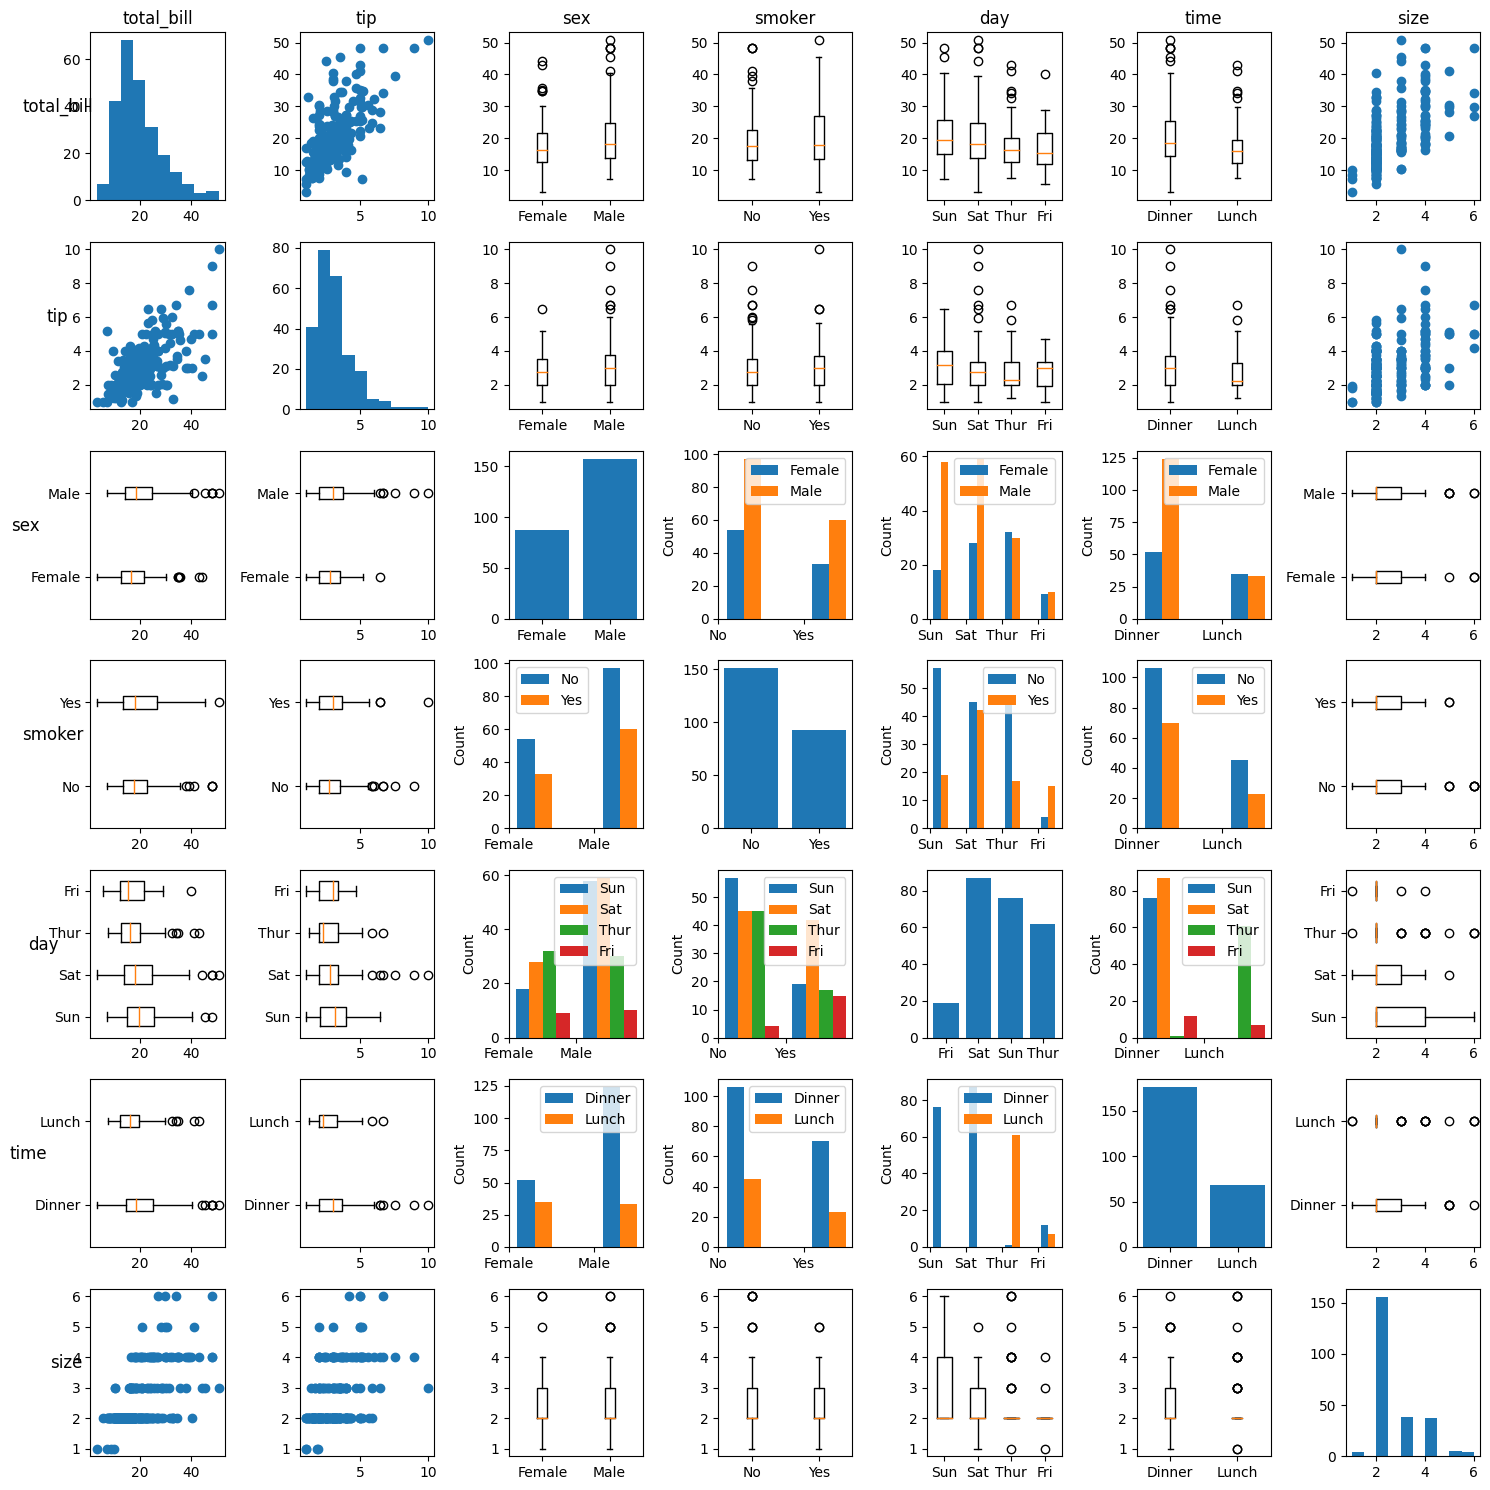

,observations,entries,unique entries,missing entries,mode(s),median,mean,range,IQR,σ
feature,,,,,,,,,,
total_bill,244,244,229,0,[13.42],17.795,19.785943,"[3.07, 50.81]",10.78,8.902412
tip,244,244,123,0,[2.0],2.9,2.998279,"[1.0, 10.0]",1.5625,1.383638
sex,244,244,2,0,[Male],NaN,NaN,NaN,NaN,NaN
smoker,244,244,2,0,[No],NaN,NaN,NaN,NaN,NaN
day,244,244,4,0,[Sat],NaN,NaN,NaN,NaN,NaN
time,244,244,2,0,[Dinner],NaN,NaN,NaN,NaN,NaN
size,244,244,6,0,[2],2.0,2.569672,"[1, 6]",1.0,0.9511


In [156]:
# call SimpleDDA
df = SimpleDDA(dfWithMeta)
df # show dataframe

#### EXAMPLE DATASET 2
#
The second dataset is a slightly modified version of this dataset from kaggle:
https://www.kaggle.com/datasets/arashnic/hr-analytics-job-change-of-data-scientists

"This dataset designed to understand the factors that lead a person to leave current job for HR researches too"

I selected this dataset because it made for an interesting test case since it has missing entries, ordinal and interval values.

In [157]:
experience = pd.read_csv('experience.csv', usecols=[2, 3, 6, 8])
# test['education_level'].unique()
experience

,city_development_index,gender,education_level,experience
0,0.827,Male,Graduate,[1-10]
1,0.920,Female,Graduate,[1-10]
2,0.624,Male,High School,<1
3,0.827,Male,Masters,[11-20]
4,0.920,Male,Graduate,>20
...,...,...,...,...
2124,0.920,Male,Graduate,[11-20]
2125,0.897,Male,Masters,[11-20]
2126,0.887,Male,Primary School,[1-10]
2127,0.804,Male,High School,[1-10]


The above contains ten sample rows from "experience.csv".
Here is a description of each feature:

-   'city_development_index': index representing the development of the city candidate is located in, interval variable
-    gender: gender of candidate, nominal variable
-    education_level: education level of candidate, ordinal variable
-    experience: Candidate total experience in years, ordinal variable

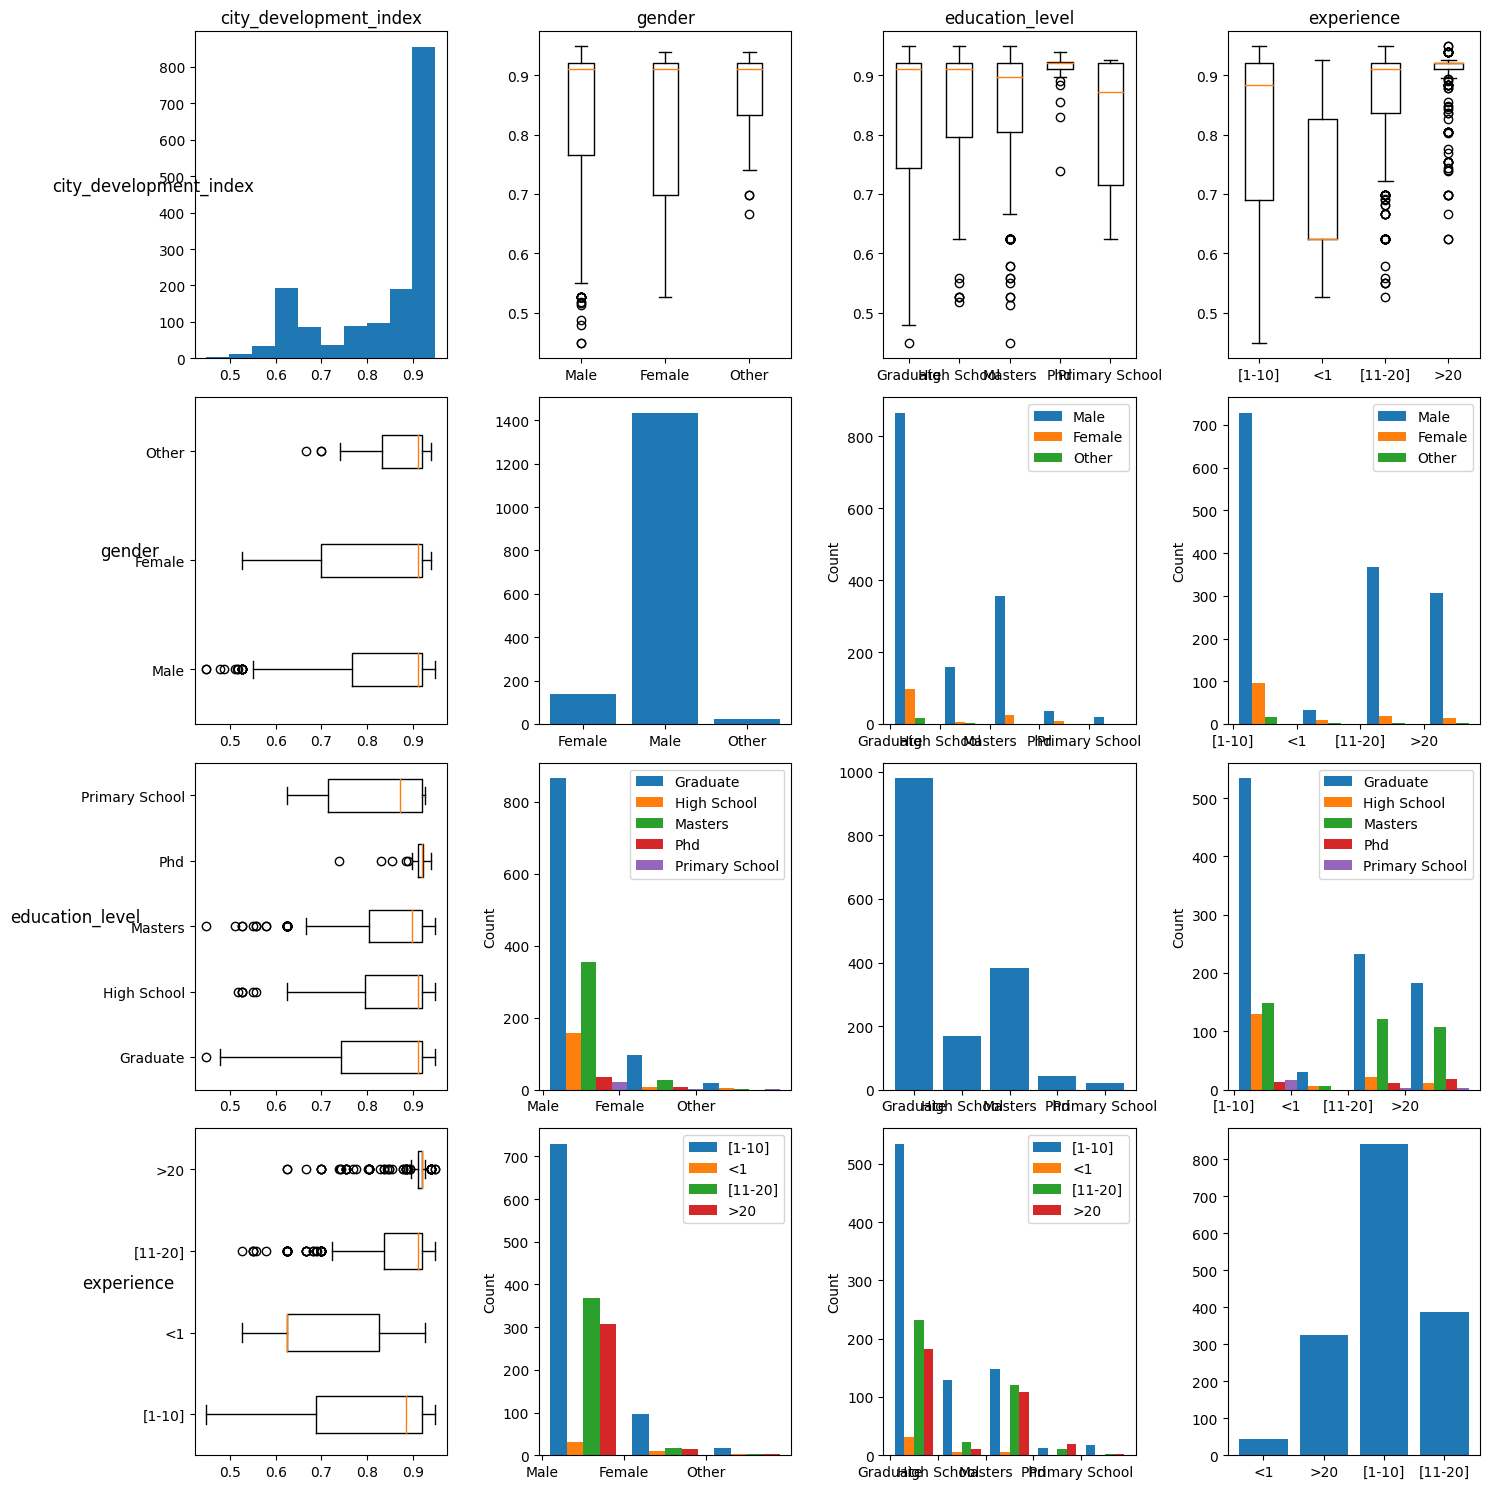

,observations,entries,unique entries,missing entries,mode(s),median,mean,range,IQR,σ
feature,,,,,,,,,,
city_development_index,2129,2129,81,0,[0.92],0.903,0.824984,"[0.448, 0.949]",0.222,0.125074
gender,2129,1621,3,508,[Male],NaN,NaN,NaN,NaN,NaN
education_level,2129,2077,5,52,[Graduate],Graduate,NaN,"[Primary School, Phd]",NaN,NaN
experience,2129,2129,4,0,[[1-10]],[1-10],NaN,"[<1, >20]",NaN,NaN


In [158]:
# create dfWithMeta
data_type = pd.Series({'city_development_index': 'interval', 'gender': 'nominal', 'education_level': 'ordinal', 'experience': 'ordinal'})
ordinal_values = {'education_level':['Primary School', 'High School', 'Graduate', 'Masters', 'Phd'], 'experience': ['<1', '[1-10]', '[11-20]', '>20']}
dfWithMeta = pd.Series({'df': experience, 'data_types': data_type, 'ordinal_values': ordinal_values})

# call SimpleDDA
df = SimpleDDA(dfWithMeta)
df # show dataframe

#### EXAMPLE DATASET 3
#
The third test dataset is a subset of the titanic survival dataset.

In [159]:
titanic = pd.read_csv('titanic.csv', usecols=[1,4,5,9])
titanic

,Survived,Sex,Age,Fare
0,0,male,22.0,7.2500
1,1,female,38.0,71.2833
2,1,female,26.0,7.9250
3,1,female,35.0,53.1000
4,0,male,35.0,8.0500
...,...,...,...,...
886,0,male,27.0,13.0000
887,1,female,19.0,30.0000
888,0,female,NaN,23.4500
889,1,male,26.0,30.0000


The above contains ten sample rows from "experience.csv".
Here is a description of each feature:

-   'Survived': Whether passenger survived (1) or not (0), nominal variable
-    Sex: Sex of passenger, nominal variable
-    Age: Age of passenger, ratio variable
-    Fare: Ticket fare, ratio variable

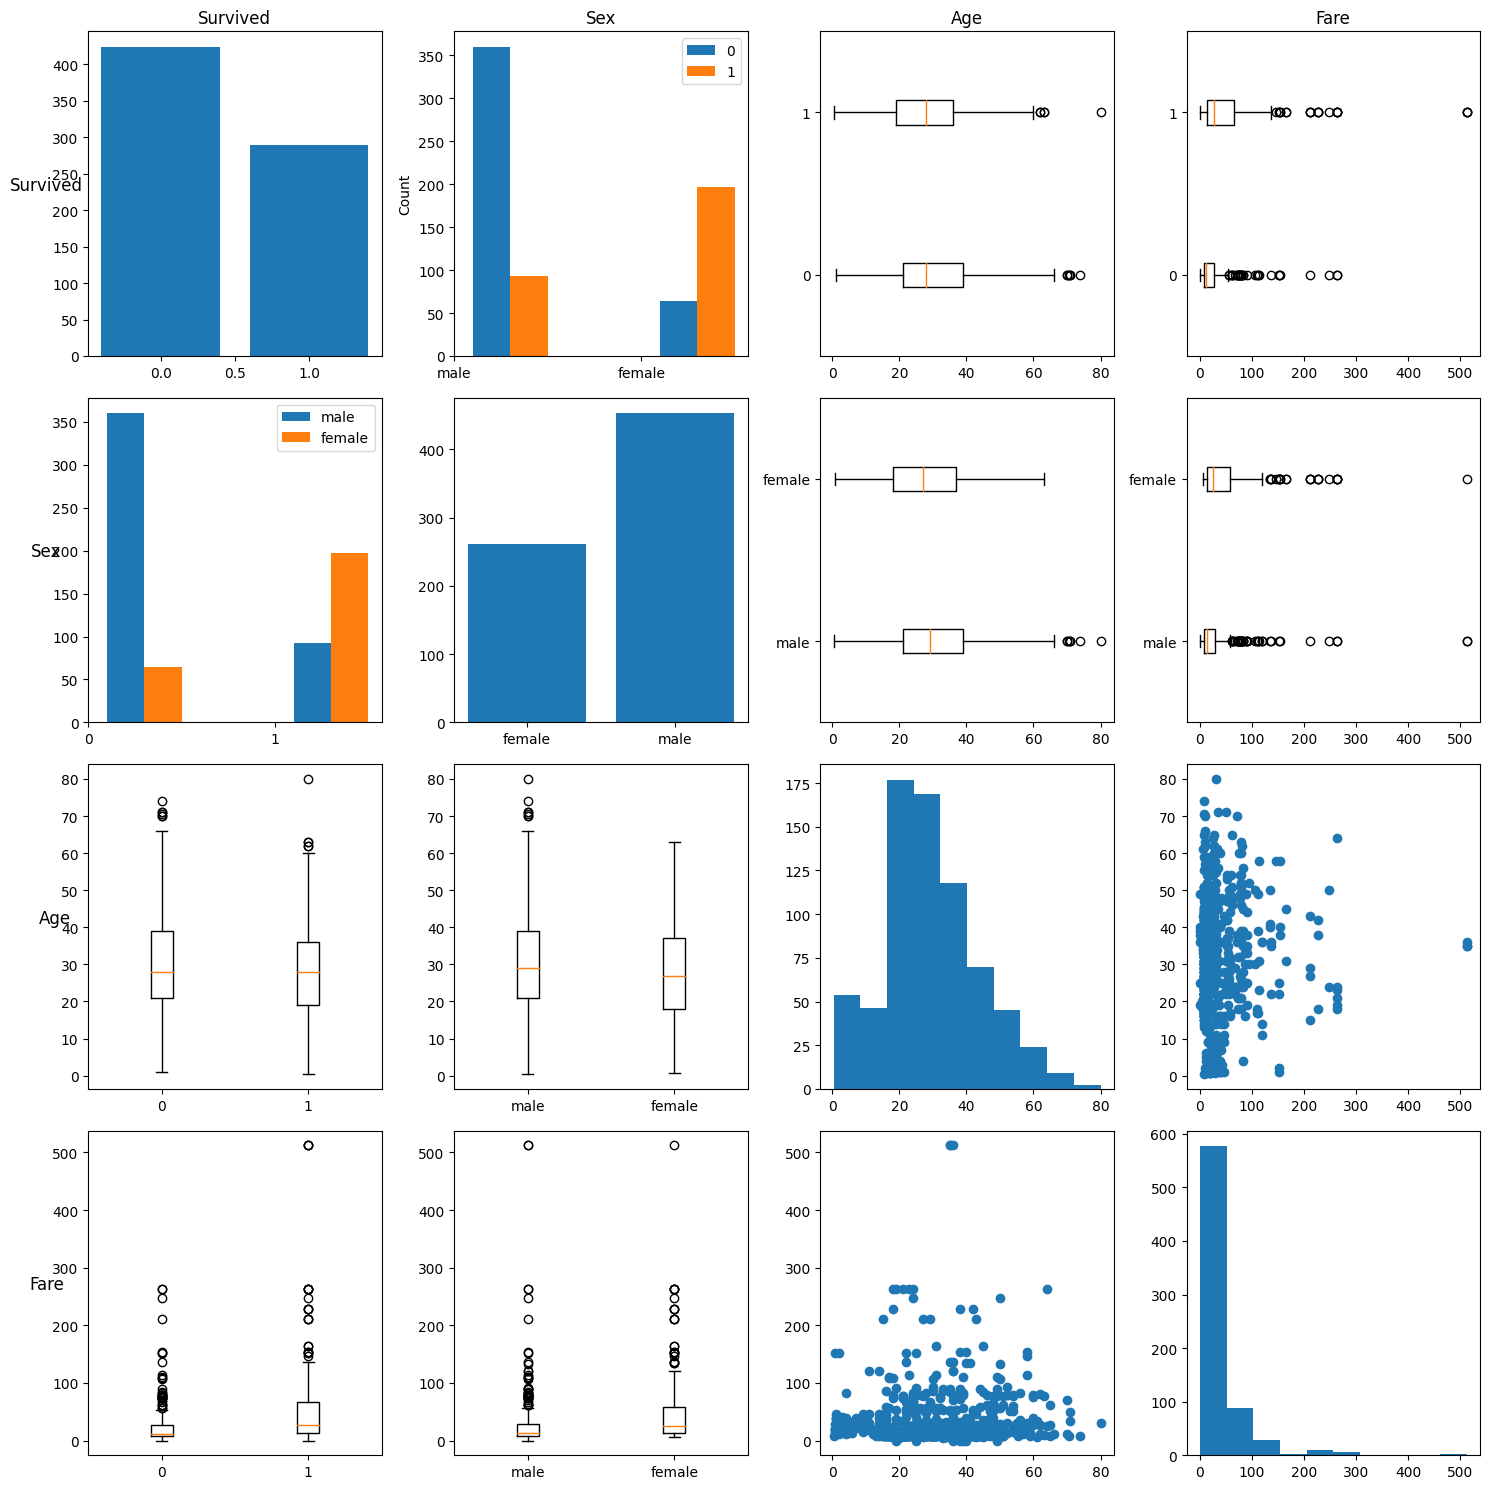

,observations,entries,unique entries,missing entries,mode(s),median,mean,range,IQR,σ
feature,,,,,,,,,,
Survived,891,891,2,0,[0],NaN,NaN,NaN,NaN,NaN
Sex,891,891,2,0,[male],NaN,NaN,NaN,NaN,NaN
Age,891,714,88,177,[24.0],28.0000,29.699118,"[0.42, 80.0]",NaN,14.526497
Fare,891,891,248,0,[8.05],14.4542,32.204208,"[0.0, 512.3292]",23.0896,49.693429


In [160]:
# create dfWithMeta
data_type = pd.Series({'Survived': 'nominal', 'Sex': 'nominal', 'Age': 'ratio', 'Fare': 'ratio'})
dfWithMeta = pd.Series({'df': titanic, 'data_types': data_type, 'ordinal_values': np.nan})

# call SimpleDDA
df = SimpleDDA(dfWithMeta)
df # show dataframe